# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sksurv.datasets import load_whas500, load_gbsg2, load_aids
import data_processing
import plots
import models

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


# Generate synthetic data

In [12]:
orig_data = data_processing.load_prepare_breast_cancer_rna_dataset()
orig_data.head(100)

,ACTB,ANKRD17,ARID1A,ARID1B,ARID5B,ATM,ATR,B2M,BCL10,BCL2,...,WAC,XPO1,YY1,ZBTB7A,ZEB2,ZFAT,ZNF292,ZNF608,censor,time
0,-0.465,0.153,-0.205,-0.054,0.259,-0.129,-0.022,-0.503,0.225,0.368,...,-0.157,-0.064,-0.297,-0.294,0.376,0.329,-0.147,0.212,0,17.936
1,0.002,-0.011,-0.098,-0.011,-0.008,0.009,-0.081,-0.926,-0.013,0.393,...,-0.078,-0.098,0.138,0.053,-0.008,0.263,-0.030,0.183,0,79.648
2,-0.185,0.032,-0.088,-0.026,0.030,0.028,-0.090,-0.096,-0.017,0.761,...,-0.110,-0.086,0.041,-0.079,-0.163,-0.023,-0.359,-0.007,0,56.848
3,0.728,0.033,-0.764,-0.764,0.017,0.680,0.000,0.008,-0.006,0.670,...,-0.025,0.557,0.683,0.037,-0.001,0.015,0.050,-0.003,0,69.616
4,-0.099,-0.022,-0.364,-0.012,-0.008,-0.012,-0.025,0.070,0.005,0.026,...,-0.109,-0.042,-0.068,0.033,-0.061,0.057,-0.089,-0.018,0,86.032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.480,0.360,0.341,-0.078,0.299,-0.282,-0.097,-0.260,0.278,0.339,...,-0.286,-0.290,-0.362,-1.019,0.429,0.195,-0.190,0.248,0,58.672
96,-0.083,-0.078,0.160,-0.101,0.005,-0.063,-0.552,0.389,-0.009,-0.023,...,-0.056,0.644,-0.075,-0.367,-0.023,-0.234,0.016,0.000,1,79.344
97,0.365,-0.162,0.137,-0.176,0.442,-0.113,-0.133,-0.155,-0.143,-0.187,...,0.278,1.568,0.442,-0.045,0.292,0.021,-0.176,0.426,0,337.440
98,-0.262,0.448,-0.223,-0.169,0.424,-0.171,0.412,-0.738,0.351,2.141,...,0.009,-0.348,0.074,-0.428,0.602,0.255,-0.685,0.278,0,36.784


In [13]:
_, df_syn = data_processing.generate_synthetic_data(orig_data, 40000)

[2024-05-19T10:21:13.273438+0300][11548][CRITICAL] module disabled: C:\Users\asafk\Desktop\Technion\Semester_7\Project\pythonProject\.venv\lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
INFO:datasets:PyTorch version 1.13.1 available.
[2024-05-19T10:21:19.254001+0300][11548][CRITICAL] module disabled: C:\Users\asafk\Desktop\Technion\Semester_7\Project\pythonProject\.venv\lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
  9%|▉         | 949/10000 [49:55<7:56:08,  3.16s/it] 


In [14]:
time, censor = data_processing.determine_censor_time(df_syn)
# we can generate extra data and use only the censored samples from a given point to get a dataset with higher censoring percentage 
df_tmp = df_syn.iloc[20001:40000, :]
df_tmp2 = df_syn.iloc[0:20001, :]
df_tmp2 = pd.concat([df_tmp2, df_tmp.loc[(df_tmp['time'] < time) & (df_tmp['censor'] == False)]])

In [15]:
df_syn = df_tmp2
df_syn.to_excel('datasets/syn/breast_cancer_rna_40k.xlsx')

# Experiment
## Load pre-saved data

In [17]:
df_syn = pd.read_excel("datasets/syn/breast_cancer_10000.xlsx", index_col=0)

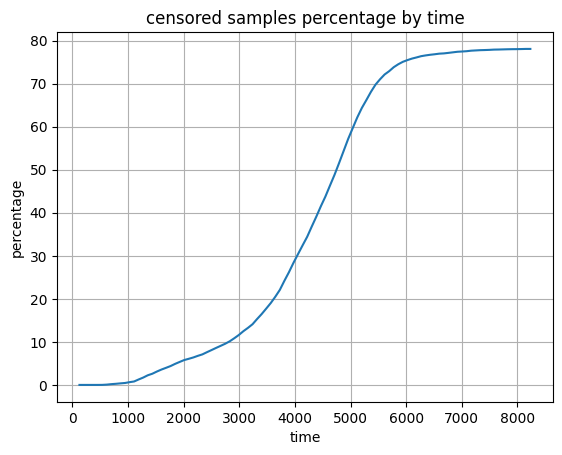

In [20]:
# plot censored percentage by time if we want to manually pick the timeframe, can also use data_processing.determine_censor_time
plots.censored_by_time_plot(df_syn)
# params dict for hyperparameter tuning
params = {'n_estimators': [100, 250], 'max_depth': [8, 16, 32, 64, None], 'min_samples_split': [10, 50, 100, 200], 'max_features': ['sqrt', 'log2', 0.5, 1]}

## Hyperparameter tuning

In [21]:
# set censor time manually
censor_time = 5500

In [23]:
# if we want to use default params
rsf_params = None
rfc_params = None

In [ ]:
rsf_params, best_auc_rsf = models.model_tuning_rsf(df_syn, censor_time, params, 3)

In [ ]:
datasets = data_processing.create_datasets(df_syn, censor_time)
rfc_params, best_auc_rfc = models.model_tuning(datasets['uncensored']['X_train'],datasets['uncensored']['y_train'], RandomForestClassifier(), params, verbose=3)

In [ ]:
print(f"rsf params: {rsf_params}")
print(f"rfc params: {rfc_params}")

## Train and score models

In [24]:
# if we want to manually change params
rsf_params = {'n_estimators': 250, 'max_depth': 24, 'min_samples_split': 10, 'max_features': 'log2'}

In [ ]:
rfc_params = {'max_depth': 64, 'min_samples_leaf': 5, 'n_estimators': 100}

In [ ]:
import experiments
rfc_auc_mean = 0
_, top_percent = data_processing.determine_censor_time(df_syn)
censor_vals = [x / 100.0 for x in range(0, int(top_percent), 10)]
print(f'censored ratios: {censor_vals}')
rsf_auc_mean = np.zeros(len(censor_vals))
num_experiments = 10
# censor_time, _ = data_processing.determine_censor_time(df_syn)
for i in tqdm(range(num_experiments)):
    rfc_auc, rsf_aucs = experiments.rsf_rfc(df_syn, censor_vals, censor_time, rsf_params, rfc_params)
    rfc_auc_mean += rfc_auc
    rsf_auc_mean += np.asarray(rsf_aucs)
rfc_auc_mean /= num_experiments
rsf_auc_mean /= num_experiments

censored ratios: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]


 88%|████████▊ | 7/8 [02:41<00:29, 29.25s/it]

In [ ]:
plots.line_plot(rsf_auc_mean, rfc_auc_mean, censor_vals, 10, 'breast cancer')

In [12]:
experiments.exp_report(df_syn, 'aids_base_models', censor_vals, censor_time, rsf_params, rfc_params, {'rfc_auc_mean': rfc_auc_mean, 'rsf_auc_mean': rsf_auc_mean})